# Housing Prices Predictor Model Selection

## 1.Preprocessing Pipeline

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn import set_config
set_config(transform_output="pandas")

# reading
url = "https://drive.google.com/file/d/1lSt_xz7fdQ8t7XEKtiAPxWulC7Cxqz05/view?usp=sharing"
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
house = pd.read_csv(path)

house = house.set_index('Id')
house
# Get to know the data
#house.columns
#house.info()
# By observing the whole data it is required to set Id column to index as it represent as unique for each property.

# X and y creation
X = house.copy()
#X.duplicated()

y = X.pop('Expensive')
y


# data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

## 2.Exploration

In [ ]:
X.head()

In [ ]:
X.info()

In [12]:
X = X.drop_duplicates()

## 3.Creation of Pipeline

In [45]:
from sklearn.preprocessing import MinMaxScaler
# building the pipeline
X_cat = X.select_dtypes(exclude="number").copy()
X_num = X.select_dtypes(include="number").copy()
#X_cat
#X_num

#numerical pipeline
numeric_pipe = make_pipeline(
    SimpleImputer(strategy="mean"), MinMaxScaler())

#categorical pipeline
categoric_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="N_A"),
    OneHotEncoder(sparse_output=False,handle_unknown="ignore")
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num_pipe", numeric_pipe, X_num.columns),
        ("cat_pipe", categoric_pipe, X_cat.columns),
    ]
)

preprocessor

ColumnTransformer(transformers=[('num_pipe',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 Index(['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr', 'Fireplaces',
       'PoolArea', 'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'MSSubClass',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'Bsm...
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'BsmtFinType2',
       'HeatingQC', 'Electrical', 'Functional', 'GarageType', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence',
       'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object'))])

## 4.Modelling

### 4.1 Decision Tree

In [68]:
from sklearn.model_selection import GridSearchCV

full_pipeline = make_pipeline(preprocessor,
                              DecisionTreeClassifier())

param_grid = {
    "columntransformer__num_pipe__simpleimputer__strategy":["mean", "median"],
    "decisiontreeclassifier__max_depth": range(2, 16, 2),
    "decisiontreeclassifier__min_samples_leaf": range(2, 14, 2)
}

dtsearch = GridSearchCV(full_pipeline,
                      param_grid,
                      cv=5,
                      n_jobs=-1,
                      verbose=1)

dtsearch.fit(X_train, y_train)

scores = {"htree" : dtsearch.best_score_}

scores

Fitting 5 folds for each of 84 candidates, totalling 420 fits


{'htree': 0.9289241040314001}

In [69]:
# test accuracy
accuracy_score(dtsearch.predict(X_test), y_test)

0.934931506849315

### 4.2 KNN Approach

In [70]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

knn_full_pipeline = make_pipeline(preprocessor,
                                StandardScaler(),
                              KNeighborsClassifier())

knn_param_grid = {
    "columntransformer__num_pipe__simpleimputer__strategy":["mean", "median"],
    "kneighborsclassifier__n_neighbors": range(2,60),
    "kneighborsclassifier__weights": ["uniform", "distance"]
}

knn_search = GridSearchCV(knn_full_pipeline,
                      knn_param_grid,
                      cv=5,
                      n_jobs= -1,
                      verbose=1)

knn_search.fit(X_train, y_train)
scores["knn"] = knn_search.best_score_

scores

Fitting 5 folds for each of 232 candidates, totalling 1160 fits


{'htree': 0.9289241040314001, 'knn': 0.9280767396647225}

In [71]:
# test accuracy
accuracy_score(knn_search.predict(X_test), y_test)


0.934931506849315

### 4.3 Random Forest Approach


In [118]:
from sklearn.ensemble import RandomForestClassifier

random_full_pipeline = make_pipeline(preprocessor,
                                StandardScaler(),
                             RandomForestClassifier())

random_param_grid = {
    "columntransformer__num_pipe__simpleimputer__strategy":["mean", "median"],
    "randomforestclassifier__n_estimators": range(100,200,50),
    "randomforestclassifier__criterion": ["gini", "entropy"],
    "randomforestclassifier__max_depth": range(2,10,2),
    "randomforestclassifier__min_samples_leaf": range(1,4)
}

random_search = GridSearchCV(random_full_pipeline,
                      random_param_grid,
                      cv=7,
                      n_jobs=-1,
                      verbose=1)

In [120]:
random_search.fit(X_train, y_train)

Fitting 7 folds for each of 96 candidates, totalling 672 fits


GridSearchCV(cv=7,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num_pipe',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         Index(['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr', 'Fireplaces',
       'PoolArea', 'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'MSSubClass',
       'OverallQual', 'Overa...
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'columntransformer__num_pipe__simpleimputer__strategy': ['mean',
                                                                                  'median'],
                         'randomforestclassifier__criterion': ['gini',
                                                               'entropy'],
                         'randomforestclassifier__max_depth': range(2, 10, 2),
                         'randomforestclassifier__min_samples_leaf': range(1, 4),
                         'randomforestclassifier__n_estimators': range(100, 200, 50)},
             verbose=1)

In [121]:
scores["random"] = random_search.best_score_
scores

{'htree': 0.9289241040314001,
 'knn': 0.9280767396647225,
 'random': 0.9477671163696703}

In [122]:
accuracy_score(random_search.predict(X_test), y_test)

0.9657534246575342

## 5.Score Analysis

In [123]:
#Score analysis of models
Train = [0.929 , 0.928 , 0.947]
Test = [0.935 , 0.935 , 0.965]
mod = pd.DataFrame([Train, Test],
                                  columns = ["Decision Tree" ,"KNN" , "Random Forest" ],
                                  index = ["Train", "Test"])
mod

,Decision Tree,KNN,Random Forest
Train,0.929,0.928,0.947
Test,0.935,0.935,0.965


## 6.Error Analysis

### 6.1 Decision Tree

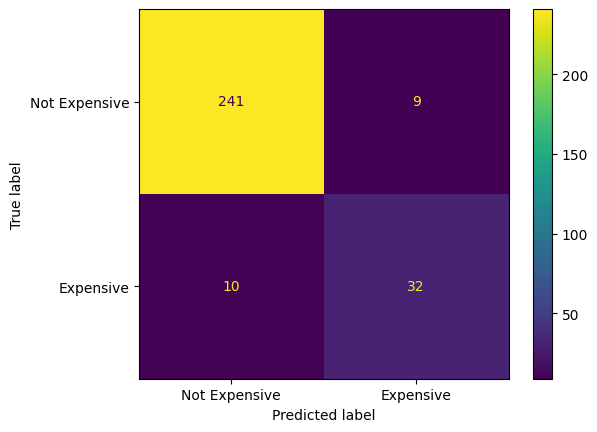

In [78]:
#Confusion Matrix for Decision Tree
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(dtsearch,
                                      X_test,
                                      y_test,
                                      display_labels=["Not Expensive", "Expensive"]);


### 6.2 KNN

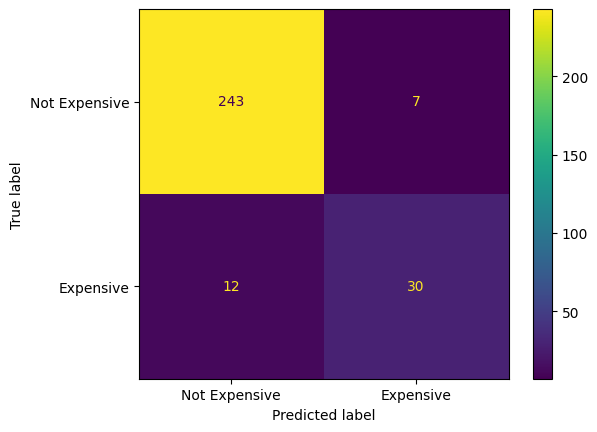

In [79]:
#Confusion Matrix for KNN
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(knn_search,
                                      X_test,
                                      y_test,
                                      display_labels=["Not Expensive", "Expensive"]);

### 6.3 Random Forest

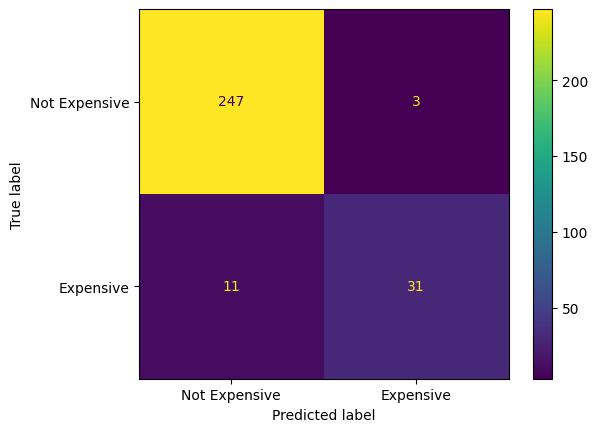

In [80]:
#Confusion Matrix for Random Forest
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(random_search,
                                      X_test,
                                      y_test,
                                      display_labels=["Not Expensive", "Expensive"]);

## 7. Fit one last time on Train Data

In [124]:
random_full_pipeline.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  Index(['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr', 'Fireplaces',
       'PoolArea', 'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'MSSubClass',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRem...
       'Neighborhood', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'BsmtFinType2',
       'HeatingQC', 'Electrical', 'Functional', 'GarageType', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence',
       'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object'))])),
                ('standardscaler', StandardScaler()),
                ('randomforestclassifier', RandomForestClassifier())])

## 8.Predict on Testing Data

### 8.1 Import Test Data

In [125]:
url = "https://drive.google.com/file/d/1dnPYCj7H1wB2FgL6cUs4_9idrQXm1NoG/view?usp=sharing"
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
testing_data = pd.read_csv(path)
testing_data

,LotArea,LotFrontage,TotalBsmtSF,BedroomAbvGr,Fireplaces,PoolArea,GarageCars,WoodDeckSF,ScreenPorch,MSZoning,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,11622,80.0,882.0,2,0,0,1.0,140,120,RH,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1,14267,81.0,1329.0,3,0,0,1.0,393,0,RL,...,Attchd,Unf,TA,TA,Y,NaN,NaN,Gar2,WD,Normal
2,13830,74.0,928.0,3,1,0,2.0,212,0,RL,...,Attchd,Fin,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
3,9978,78.0,926.0,3,1,0,2.0,360,0,RL,...,Attchd,Fin,TA,TA,Y,NaN,NaN,NaN,WD,Normal
4,5005,43.0,1280.0,2,0,0,2.0,0,144,RL,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,1936,21.0,546.0,3,0,0,0.0,0,0,RM,...,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,WD,Normal
1455,1894,21.0,546.0,3,0,0,1.0,0,0,RM,...,CarPort,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
1456,20000,160.0,1224.0,4,1,0,2.0,474,0,RL,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
1457,10441,62.0,912.0,3,0,0,0.0,80,0,RL,...,NaN,NaN,NaN,NaN,Y,NaN,MnPrv,Shed,WD,Normal


In [126]:
testing_data = testing_data.set_index('Id')

Use your model's `.predict()` method to create predictions.

In [127]:
random_full_pipeline.predict(testing_data)

array([0, 0, 0, ..., 0, 0, 0])

The output of `.predict()` is an array. Save this as a column on `testing_data`.

In [128]:
testing_data['Expensive'] = random_full_pipeline.predict(testing_data)

In [129]:
testing_data

,LotArea,LotFrontage,TotalBsmtSF,BedroomAbvGr,Fireplaces,PoolArea,GarageCars,WoodDeckSF,ScreenPorch,MSZoning,...,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,Expensive
Id,,,,,,,,,,,,,,,,,,,,,
1461,11622,80.0,882.0,2,0,0,1.0,140,120,RH,...,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal,0
1462,14267,81.0,1329.0,3,0,0,1.0,393,0,RL,...,Unf,TA,TA,Y,NaN,NaN,Gar2,WD,Normal,0
1463,13830,74.0,928.0,3,1,0,2.0,212,0,RL,...,Fin,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal,0
1464,9978,78.0,926.0,3,1,0,2.0,360,0,RL,...,Fin,TA,TA,Y,NaN,NaN,NaN,WD,Normal,0
1465,5005,43.0,1280.0,2,0,0,2.0,0,144,RL,...,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,1936,21.0,546.0,3,0,0,0.0,0,0,RM,...,NaN,NaN,NaN,Y,NaN,NaN,NaN,WD,Normal,0
2916,1894,21.0,546.0,3,0,0,1.0,0,0,RM,...,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml,0
2917,20000,160.0,1224.0,4,1,0,2.0,474,0,RL,...,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml,0


## 7.Final Submission

In [130]:
# Export the column 'Expensive' along with the index to create a submission file
#testing_data['Expensive'].to_csv('./submission.csv')

In [131]:
# Colab only
#from google.colab import files
#files.download('./submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>